# 3.8.2: Penny Falling Redux

---

<br>

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey, (License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/))

Revised, Mike Augspurger (2021-present)

<br>

---

In [ ]:
#@title
# Import necessary libraries
from os.path import basename, exists
from os import mkdir

def download(url,folder):
    filename = folder + basename(url)
    if not exists(folder):
        mkdir(folder)
    # fetches the file at the given url if it is not already present
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/Notebooks/'
        + 'ModSimPy_Functions/modsim.py', 'ModSimPy_Functions/')

from ModSimPy_Functions.modsim import *
import pandas as pd
import numpy as np

In the previous chapter we simulated a penny falling in a vacuum, that
is, without air resistance. But the computational framework we used is
very general; it is relatively uncomplicated to add additional forces, including drag.  In this chapter, we'll do just that!

## The Physics of Drag

### The drag force equation

As an object moves through a fluid, like air, the object applies force
to the air and, in accordance with the third law of motion, the air applies an equal and opposite force to the object.

<br>

Drag is a "reactive force", which means that it always acts in the direction opposite to the direction of
travel.  Unlike friction, its magnitude is dependent on the velocity, and can be calculated using the drag equation:

$$F_d = \frac{1}{2}~\rho~v^2~C_d~A$$

where

-   $F_d$ is force due to drag, in newtons ($N$).

-   $\rho$ is the density of the fluid in $kg/m^3$.

-   $v$ is the magnitude of velocity in $m/s$.

-   $A$ is the the *projected frontal area* of the object in $m^2$. You can think of this as the visible area of the object as seen from a point on its line of travel.  So a falling cylinder might have an $A$ in the shape of a circle or a rectangle, depending on its orientation as it falls.

-   $C_d$ is the *drag coefficient*, a dimensionless quantity that depends on the shape of the object (including length but not frontal area), its surface properties, and how it interacts with the fluid. 

<br>

Of course, the drag equation is itself a model, based on the assumption that $C_d$ does not depend on the other terms in the equation: density, velocity, and area. If the object is moving very fast, or spinning, or if $C_D$ depends on velocity or density, the model can be less effective.

✅ Active reading: Compare the drag force on a Formula 1 car in a race versus that on a minivan on the highway.  Name 2 factors in the drag equation that suggest the drag force would be smaller on the race car, and one reason the drag force might actually be higher on the race car.

✅ ✅  Answer here.

### Determining a drag coefficient

For objects moving at moderate speeds through air, typical drag
coefficients are between 0.1 and 1.0, with blunt objects at the high end of the range and streamlined objects at the low end.

<br>

<img src = https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/Images_and_Data/Images/Drag_coef.PNG width = 500>

<br>

For simple geometric objects we can sometimes guess the drag coefficient with reasonable accuracy; for more complex objects we usually have to take measurements and estimate $C_d$ from data.

<br>

Since a falling penny would likely be rotating unpredictably, we should use measurements to estimate $C_d$. In particular, we can measure *terminal velocity*, $v_{term}$, which is
the speed where drag halts the objects' acceleration.  If we know this terminal velocity, we can use the second law of motion to find $C_d$, by naming our two forces (gravity and drag) setting the acceleration to 0:

<br>

$$\Sigma F = ma \qquad \rightarrow \qquad F_{drag} + F_{grav} =0$$

<br>

This leads to:

<br> 

$$F_{drag} = - F_{grav}$$

<br>

$$\frac{1}{2}~\rho~v_{terminal}^2~C_d~A = - m g$$ 

<br>

where $m$ is the mass of the object and $g$ is acceleration due to gravity. Solving this equation for $C_d$ yields: 

<br>

$$C_d = \frac{2~m g}{\rho~v_{terminal}^2~A}$$ 

<br>

In our earlier notebook, we estimated that the terminal velocity of a penny is between 35 and 65 mph (15-30 m/s).  In our first notebooks, we set the terminal velocity to 29 m/s, so let's use that here too:

In [ ]:
from numpy import pi

v_term = 29.0         # terminal velocity, 29 m/s
rho = 1.2           # density of air, kg/m^3
g = 9.81            # gravity, m/s^2
mass = 0.0025       # mass, kg      
diameter = 0.019    # diameter, m
area = pi * (diameter/2)**2
C_d = (2.0*mass*g)/(rho*v_term**2*area)
C_d

0.1714212614288154

The density of air depends on temperature, barometric pressure (which depends on
altitude), and humidity, among other things.  This value might be typical in New York City at 20 °C.   Our $C_d$ with these parameters is about $0.17$.



✅ Active reading: If the terminal velocity of object A is higher than that of object B (assuming the same mass), is the $C_d$ larger or smaller?   Explain this in terms of the equation and in terms of the physics ("An object with a high terminal velocity falls faster because...")

✅ ✅  Answer here.

<br>

---

## Implementing the Drag Model

### Defining parameters and a system

In order to use `run_solve_ivp`, we'll need a `params` object for the falling penny (in base metric units).  Since there are a lot of parameters, we'll store this in a `dictionary` rather than just as a `tuple`  (which is what we've used in previous chapters--a `tuple` is a simple sequence of variables).  This will make it a bit easier to use the variables:


In [ ]:
params = dict(
    mass = mass,      
    diameter=diameter,   
    rho = rho,          
    g = g,            
    v_init = 0,
    v_term = v_term,        
    height = 381,       
    t_end = 30,         
    )



Here's a version of `make_system` that takes the `params` object and computes the inital state `init`, the area, and the coefficient of drag.
Then it returns a `system` object with the quantities we'll need for the simulation. 

In [ ]:
from numpy import pi

def make_system(params):
    # unpack the parameters
    mass, area, rho, g, v_init, v_term, height, t_end = params.values()
    
    init = pd.Series(dict(y=height, v=v_init))

    area = pi * (diameter/2)**2

    C_d = (2 * mass * g / 
           (rho * area * v_term**2))

    return dict(init=init,
                  area=area,
                  C_d=C_d,
                  mass=mass,
                  rho=rho,
                  g=g,
                  v_term = v_term,
                  t_end=t_end)

And here's how we call it.

In [ ]:
system = make_system(params)
system['C_d']

0.1714212614288154

We can update our `params` object by using the `copy()` and `update()` dictionary methods if we'd like to create two systems without repeating much code.  For example, suppose we learn that the terminal velocity of a penny is actually closer to 20 m/s. We can make a `params` object with the new value, and a corresponding `system` object.   The result is a new `params` object that is identical to the original except for the given value of `v_term`. 
If we pass `params1` to `make_system`, we see that it computes a different value of `C_d`.

In [ ]:
# Create a new dictionary object
params1 = params.copy()

# Update one of the terms in the new object
# Notice that update takes a dictionary as its argument
params1.update(dict(v_term=20))
system1 = make_system(params1)
print("New C_d value:", system1['C_d'])

New C_d value: 0.3604132021540844


If the terminal velocity of the penny is 20 m/s, rather than 29 m/s, that implies that the coefficient of drag is 0.36, rather than 0.17.
And that makes sense, since the lower terminal velocity implies more drag.

### Defining the Slope Function

Since the drag force depends on velocity, we will not have a constant acceleration at each time step.  Instead, we'll need to use the second law to calculate the drag force at each time step, and use that to define the acceleration that results from drag.

In [ ]:
def slope_func(t, state, system):

    y, v = state
    rho, C_d, area = system['rho'], system['C_d'], system['area']
    mass, g = system['mass'], system['g']
    
    f_drag = rho * v**2 * C_d * area / 2
    
    if v < 0:
        a_drag = f_drag / mass 
    else:
        a_drag = -f_drag / mass
    
    dydt = v
    dvdt = -g + a_drag 
    
    return dydt, dvdt

As usual, the parameters of the slope function are a time stamp, a `state` object, and a `system` object.  `f_drag` is force due to drag, based on the drag equation, and `a_drag` is
acceleration due to drag, based on the second law.

<br>

To compute total acceleration, we add accelerations due to gravity and
drag. Notice that the signs of `g` and `a_drag` indicate their directions. As usual, let's test the slope function with the initial conditions.

In [ ]:
slope_func(0, system['init'], system)

(0, -9.81)

Because the initial velocity is 0, so is the drag force, so the initial acceleration is still `g`. 

✅ Active reading:  Add inline comments (#) for `slope_func` above, using one comment for each of the 4 sections of the function.

### Running the simulation with an event function

To stop the simulation when the penny hits the sidewalk, we'll use the
event function from the previous chapter.

In [ ]:
def event_func(t, state, system):
    y, v = state
    return y

Now we can run the simulation like this:

In [ ]:
results, details = run_solve_ivp(system, slope_func,
                                 events=event_func)
details.message

'A termination event occurred.'

Here are the last few time steps:

In [ ]:
results.tail()

,y,v
14.577864,1.761281e+01,-28.999711
14.729716,1.321004e+01,-29.000358
14.881569,8.806979e+00,-29.000814
15.033422,4.403632e+00,-29.001075
15.185275,-6.394885e-14,-29.001143


The final height is close to 0, as expected.  Interestingly, the final velocity is not exactly terminal velocity, which is a reminder that the simulation results are only approximate. We can get the flight time from `results`.

In [ ]:
t_sidewalk = results.index[-1]
t_sidewalk

15.18527470330869

With air resistance, it takes about 15 seconds for the penny to reach the sidewalk.  Here's a plot of position as a function of time.

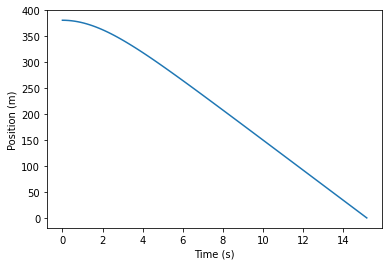

In [ ]:
results.y.plot(xlabel='Time (s)',
         ylabel='Position (m)');
    


And velocity as a function of time:

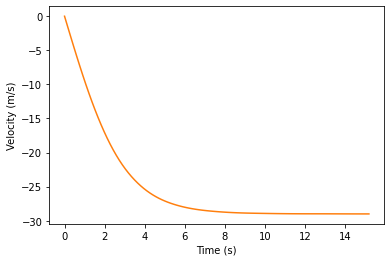

In [ ]:
results.v.plot(color='C1', label='v',
                   xlabel='Time (s)', 
                   ylabel='Velocity (m/s)');

From an initial velocity of 0, the penny accelerates downward until it reaches terminal velocity; after that, velocity is constant.

---

## Summary

This notebook iterates our differential model for a fallen penny by adding drag force. We used an estimated terminal velocity to estimate the coefficient of drag for a penny, and then simulated, one more time, dropping a penny from the Empire State Building.

<br>

---

## Exercises

### Exercise 1

What happens to the simulation, if we throw the penny up or down rather than just dropping it?

<br>

Create a couple new `params` objects using `copy()` and `update()`, and run the simulation with 1) an upward velocity and 2) downward initial velocity that exceeds the penny's terminal velocity (say, -40 m/s).

<br>

What do you expect to happen?  Plot velocity and position as a function of time, and see if they are consistent with your prediction.  Then create plots with the results from all three simulations on the same plot.

In [ ]:
# Set the params for the two new simulations using copy and update
# Then make the two new systems
params_d = params.copy()
params_d.update(dict(v_init=-40))
system_d = make_system(params_d)

params_u = params.copy()
params_u.update(dict(v_init=30))
system_u = make_system(params_u)

In [ ]:
# Use run_solve_ivp to get the results for the "throwing downward" simulation
results_d, details = run_solve_ivp(system_d, slope_func,
                                 events=event_func)
details.message

'A termination event occurred.'

In [ ]:
# Use run_solve_ivp to get the results for the "throwing upward" simulation
results_u, details = run_solve_ivp(system_u, slope_func,
                                 events=event_func)
details.message

'A termination event occurred.'

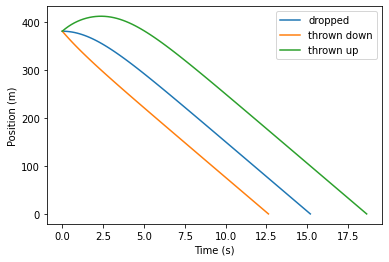

In [ ]:
# Plot the position vs. time for all three simulations
results.y.plot(xlabel='Time (s)',
         ylabel='Position (m)', label='dropped',legend=True)
results_d.y.plot(label='thrown down',legend=True)
results_u.y.plot(label='thrown up', legend=True);

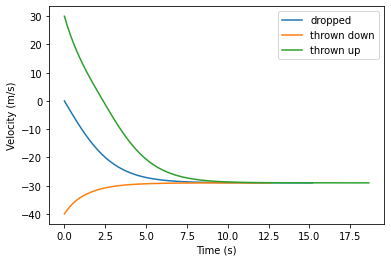

In [ ]:
# Plot the velocity vs. time for all three simulations
results.v.plot(xlabel='Time (s)',
         ylabel='Velocity (m/s)', label='dropped',legend=True);
results_d.v.plot(label='thrown down',legend=True)
results_u.v.plot(label='thrown up', legend=True);

### Exercise 2

✅ A. What effect does throwing the ball downward have on the total time required for the drop?  Use numbers in your explanation.

✅ ✅  Answer A here.

<br>

✅ B.  What happens to the velocity of the ball that is thrown downward over time?

✅ ✅  Answer B here

<br>

✅ C. In the downward-thrown model, in the first seconds, what is the relationship between the drag force and gravitational force?  Which is bigger?  What direction are each in?  How do they change over time?

✅ ✅ Answer C here.